# Intro to SMuRF
The SMuRF software consists of a server and client.  The server and client are started in docker containers.  The SMuRF server provides and EPICS channel access interface to access PVs (registers, and higher level controls) and acquires the streaming data.  It can perform filtering/downsampling for CMB applications.



## Server startup

In a separate terminal we'll start the server with:
```bash
cd /home/cryo/docker/smurf/dev_sw/slotN/v4.2.1
./run.sh -N 5; docker logs -f smurf_server_s5
```
-N 5 specifies slot 2 and EPICS server prefix smurf_server_s5

A GUI will pop up that we can use to interrogate the FPGA registers


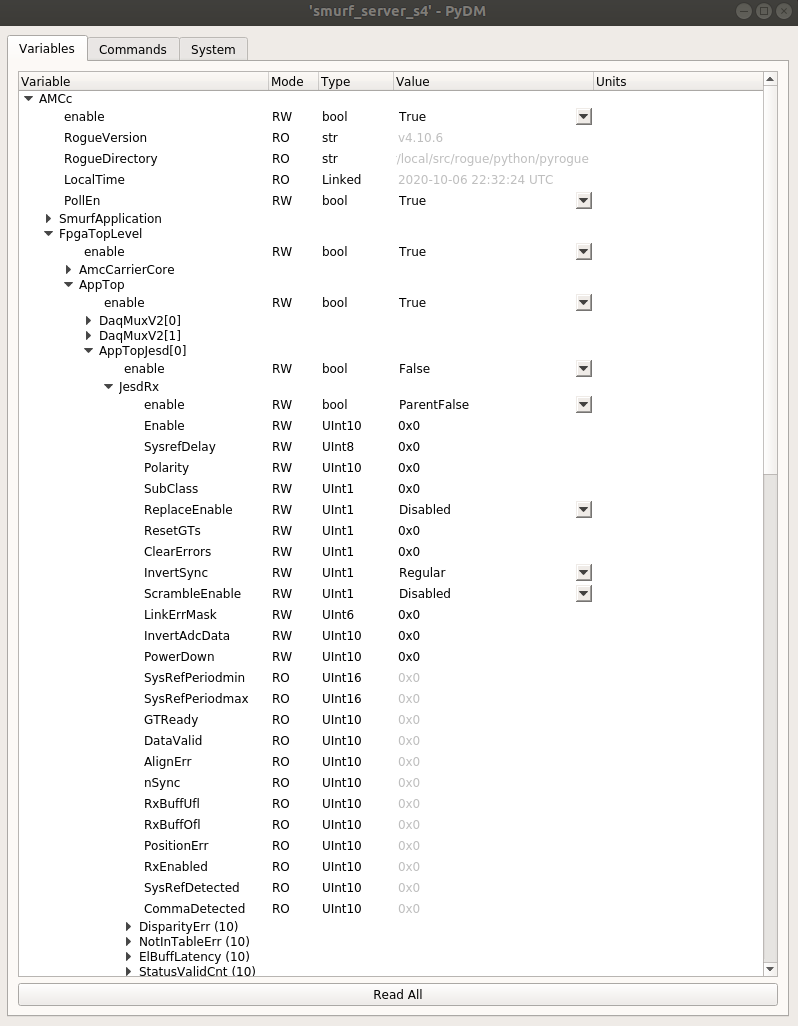

## PySMuRF Setup

PySMuRF is the client side control.  It communicates with the server via EPICS channel access (CA).  First we start the server and do imports

In [1]:
import pysmurf.client
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
import epics
import os

%matplotlib inline

Next we'll define the EPICS server prefix and experiment configuration file

In [2]:
epics_prefix = "smurf_server_s5"
config_file  = "/usr/local/src/pysmurf/cfg_files/stanford/experiment_fp31_cc03-02_lbOnlyBay0.cfg"
S = pysmurf.client.SmurfControl(epics_root=epics_prefix, cfg_file=config_file, setup=False, make_logfile=True)

Next we run a setup command.  This will initialize the FPGA and load the configuration defined in config_file.

In [3]:
S.setup()

True

Next we need to enable cryostat amplifiers bias (if using cryostat card)

In [4]:
# **** this is only used at Stanford for hacked cryostat card ****

exec(open('../shawn/cryocard_c03_setup.py').read())

-> Running cryocard_c03_setup.py ...
-> Enabling RTM DAC32, which drives DAC_In_50k_d
-> Setting DAC_In_50k_d to 0.65V for 50kVd=5.003
-> Enabling RTM DAC31, which drives DAC_In_H_d
-> Setting DAC_In_H_d to 6V for HVd=0.53
Done running cryocard_c03_setup.py.


In [5]:
S.set_amplifier_bias()
S.set_cryo_card_ps_en()
S.get_amplifier_bias()

{'hemt_Vg': 0.27999861000000004,
 'hemt_Id': 3.796246874999999,
 '50K_Vg': -0.7899972599999999,
 '50K_Id': 65.7421875}

### Inspecting the SMuRF digitizers

SMuRF uses x8 RF ADCs and x8 RF DACs.  They are upmixed and combined in via x2 quadruplexers to form 4GHz analog bandwidth from 4-8GHz.  SMuRF uses a 750MHz intermediate frequency withand the RF ADCs and DACs perform down/up conversion to/from complex baseband.  






The digitizers are upmixed and combined with a multiplexer:

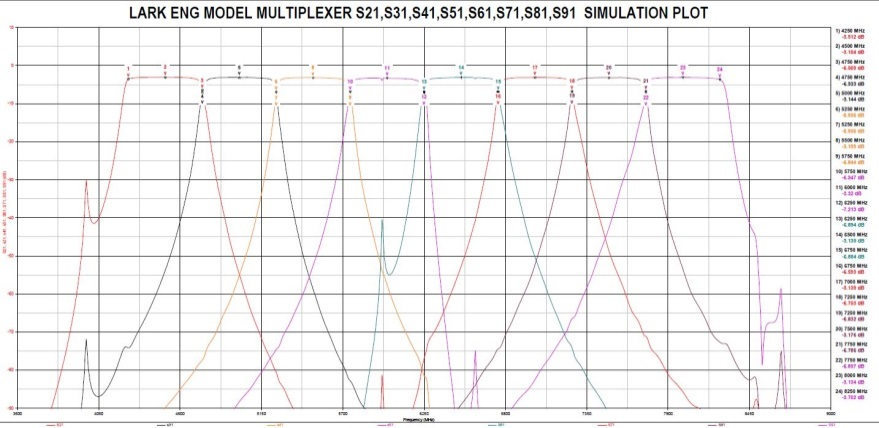

### Acquiring data from the digitzers

The SMuRF ADC and DACs are pictured below.  We can interrogate the raw ADC/DAC data with the following commands.  Here "band" defines which ADC/DAC to read data from.  Band 0...3 address AMC in the slot 0 and (when using low band AMC) correspond to 4-4.5GHz, 4.5-5GHz, 5-5.5GHz, and 5.5-6GHz.  Band 4...7 address the AMC in slot 1 and (when using the high band AMC) correspond to 6-6.5GHz, 6.5-7GHz, 7-7.5GHz and 7.5-8GHz.

The raw digitizer data is plotted in the top and a PSD is plotted below.  Raw data are 16-bit numbers +32767/-32768.  Let's look at the ADC data with no signals being played out of the DAC.



In [6]:
adc_data = S.read_adc_data(data_length=2**16, band=3, make_plot=True, show_plot=True)

In [7]:
dac_data = S.read_dac_data(data_length=2**16, band=0, make_plot=True, show_plot=True)

/usr/local/src/pysmurf/python/pysmurf/client/util/smurf_util.py:1724: RuntimeWarning: divide by zero encountered in log10
  ax2.plot(f_plot, 10*np.log10(p_dac))


Note the PSD frequency is plotted +/- 0MHz. Each digitizer has complex data at 614.4MHz corresponding to +/- 307.2MHz BW at baseband.  For band=2 this is 0MHz + 5250MHz = 5250MHz.


### Transfer function of the system

Next we can look at a transfer function estimate.  This will play a known random number sequence through the DAC and record the ADC response.  We'll use cross correlation to generate a transfer function estimate:

In [8]:
S.full_band_resp(band=2, make_plot=True, show_plot=True)

/usr/local/lib/python3.6/dist-packages/scipy/signal/spectral.py:1812: UserWarning: Input data is complex, switching to return_onesided=False
  warnings.warn('Input data is complex, switching to '


(array([-3.07200000e+08, -3.07197656e+08, -3.07195312e+08, ...,
         3.07192969e+08,  3.07195312e+08,  3.07197656e+08]),
 array([ 5.58350327e-05-0.0090639j ,  9.38725975e-03-0.00349163j,
         2.82754308e-03-0.0009932j , ..., -1.00628966e-02-0.00757017j,
        -2.18176138e-03-0.01508286j,  4.08789240e-03-0.00790381j]))

Here we can see transmission through the cryostat with a number of resonators at +/- 250MHz from the band 2 center (5250MHz).

### Calibrating cable delay

There is a few microsecond delay through SMuRF -> cryostat -> signal processing.  Now that we have good transmission let's calibrate the delay.

/usr/local/lib/python3.6/dist-packages/scipy/signal/spectral.py:1812: UserWarning: Input data is complex, switching to return_onesided=False
  warnings.warn('Input data is complex, switching to '


-------------------------------------------------------
Estimated refPhaseDelay=22
Estimated refPhaseDelayFine=81
Estimated processing_delay_us=8.165499371355265
-------------------------------------------------------


(22, 81, 8.165499371355265, 0.018891376348960737)

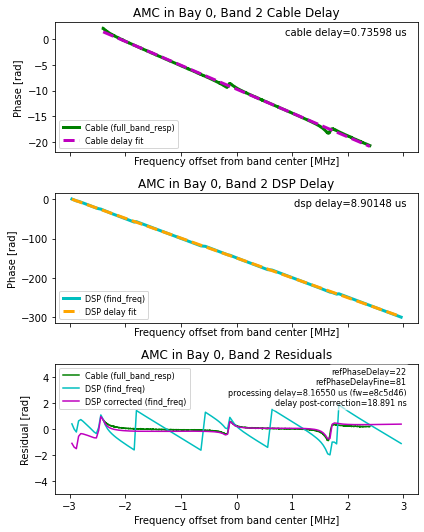

In [9]:
S.estimate_phase_delay(band=2)

### Identifying resonator locations

Each SMuRF band is processed by an oversampled x2 polyphase filter bank.  The filter bank breaks the +/-307.2MHz band into subbands.  Subband 0...511 correspond to -307.2MHz...307.2MHz.  Only subbands +/-250MHz are processed.  We can do a tone sweep to see the subband structure and identify resonator locations within each subband.  The plot shows the interleaved subbands in different colors.

/usr/local/src/pysmurf/python/pysmurf/client/tune/smurf_tune.py:896: RuntimeWarning: invalid value encountered in double_scalars
  if 1-amp[idx]/med_amp[idx] > amp_cut:


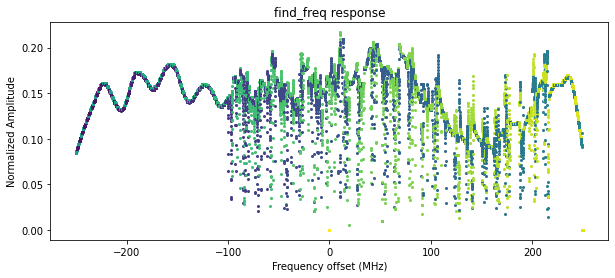

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([[0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
        ...,
        [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j]]))

In [10]:
S.find_freq(band=2, start_freq=-250, stop_freq=250, make_plot=True, show_plot=True)

### Fine resolution resonator scans
Next we run a fine resonator scan and set the nominal tone frequency, drive power and rotation.  Feedback operates on the RF demodulated Q and performs feedback to drive Q to 0.  Serial gradient descent will walk down to the bottom of the resonator dip.  Finally the eta scan will apply rotation and scaling such that Q -> delta frequency from bottom of the dip.

In [11]:
S.setup_notches(band=2, new_master_assignment=True)
# Plots will be saved in S.plot_dir
S.plot_tune_summary(band=2, eta_scan=True)
print("These plots are saved at: " + S.plot_dir)
# run a gradient descent to find resonator dip
S.run_serial_gradient_descent(0) 
# run eta scan to normalize resonator gain (delta Q -> delta frequency) and apply rotation such that Q is nominally 0
S.run_serial_eta_scan(0) 

These plots are saved at: /data/smurf_data/20210126/1611699241/plots


Here's our eta scan, the complex response is multiplied by the complex value eta to apply the scaling/rotation for feedback.

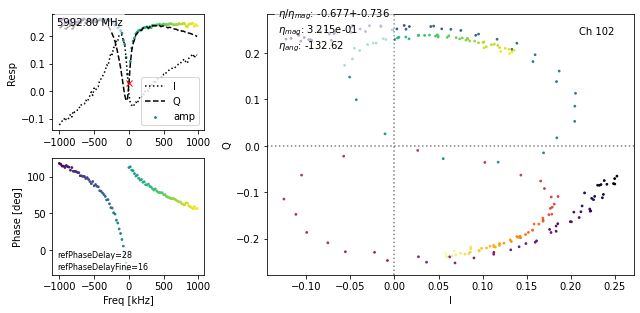

### Looking at on resonance noise
Now we can examine resonator noise.  The eta scan sets up with feedback enabled so we'll turn it off and look at open loop frequency error (quadrature voltage).

First we'll get of list of resonators that are on and tracking:

In [12]:
S.which_on(band=2)

array([  0,   2,   7,  16,  18,  20,  23,  26,  27,  34,  42,  44,  47,
        48,  52,  55,  56,  64,  68,  74,  82,  90,  91,  92,  95,  96,
       100, 112, 114, 116, 123, 132, 136, 143, 146, 151, 152, 156, 162,
       167, 170, 172, 175, 176, 187, 191, 196, 199, 200, 202, 212, 216,
       219, 223, 224, 232, 239, 251, 252, 255, 256, 258, 260, 271, 274,
       279, 282, 284, 287, 288, 290, 298, 304, 308, 312, 315, 319, 327,
       328, 335, 338, 340, 344, 348, 352, 356, 359, 360, 363, 370, 375,
       379, 383, 388, 391, 392, 402, 407, 410, 411, 416, 418, 420, 426,
       428, 431, 439, 443, 448, 450, 455, 460, 463, 464, 468, 472, 479,
       488, 490, 491, 498, 500, 508])

Text(0, 0.5, 'Frequency error (MHz)')

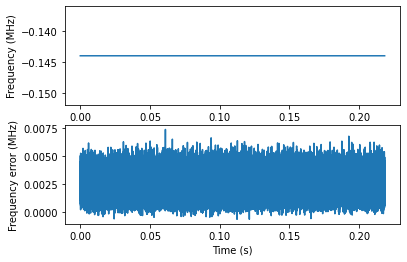

In [13]:
S.set_feedback_enable(band=2, val=0)
channel = 0
fs = 2.4e6
f, df, sync = S.take_debug_data(band=2, channel=channel, nsamp=2**19, IQstream=0, single_channel_readout=2)
t = np.arange(len(df))/fs
plt.subplot(211)
plt.plot(t, f)
plt.xlabel('Time (s)')
plt.ylabel('Frequency (MHz)')
plt.subplot(212)
plt.plot(t, df)
plt.xlabel('Time (s)')
plt.ylabel('Frequency error (MHz)')

Text(0.5, 1.0, 'Frequency error PSD')

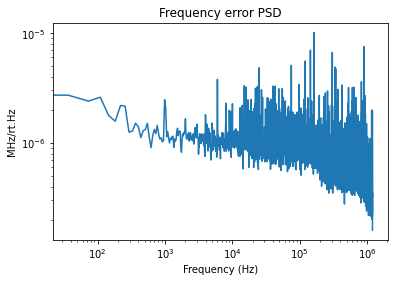

In [14]:
freq, pxx = signal.welch(df, nperseg=len(df)/8, fs=fs)
plt.loglog(freq, np.sqrt(pxx))
plt.xlabel('Frequency (Hz)')
plt.ylabel('MHz/rt.Hz')
plt.title('Frequency error PSD')

Now let's enable feedback and look at frequency and frequency error

Text(0, 0.5, 'Frequency error (MHz)')

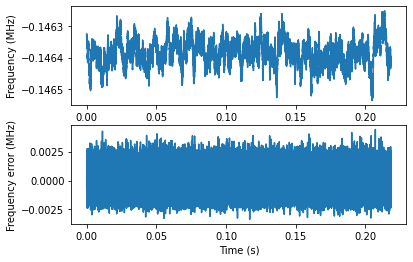

In [15]:
S.set_feedback_enable(band=2, val=1)
fs = 2.4e6
f, df, sync = S.take_debug_data(band=2, channel=channel, nsamp=2**19, IQstream=0, single_channel_readout=2)
t = np.arange(len(df))/fs
plt.subplot(211)
plt.plot(t, f)
plt.xlabel('Time (s)')
plt.ylabel('Frequency (MHz)')
plt.subplot(212)
plt.plot(t, df)
plt.xlabel('Time (s)')
plt.ylabel('Frequency error (MHz)')

Text(0.5, 1.0, 'Tracked frequency PSD')

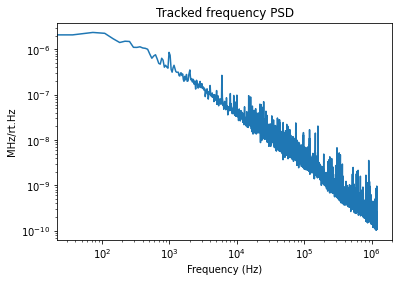

In [16]:
freq, pxx = signal.welch(f, nperseg=len(df)/8, fs=fs)
plt.loglog(freq, np.sqrt(pxx))
plt.xlabel('Frequency (Hz)')
plt.ylabel('MHz/rt.Hz')
plt.title('Tracked frequency PSD')

Text(0.5, 1.0, 'Frequency error PSD')

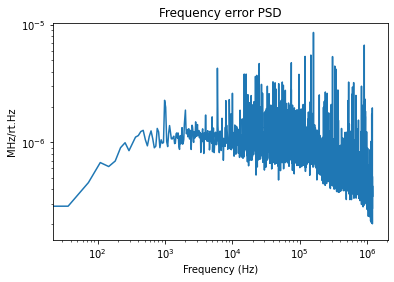

In [17]:
freq, pxx = signal.welch(df, nperseg=len(df)/8, fs=fs)
plt.loglog(freq, np.sqrt(pxx))
plt.xlabel('Frequency (Hz)')
plt.ylabel('MHz/rt.Hz')
plt.title('Frequency error PSD')

We can change feedback gain and look at tracked frequency response

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previo

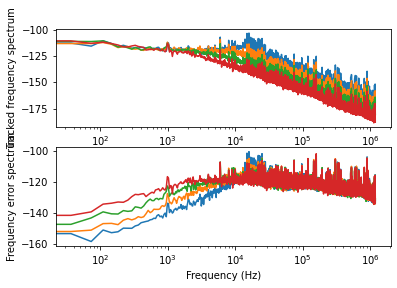

In [18]:
S.flux_ramp_off()
S.toggle_feedback(band=2)
gain = [8192, 4096, 2048, 1024]

for g in gain:
    S.set_feedback_gain(band=2, val=g)
    f, df, sync = S.take_debug_data(band=2, channel=channel, nsamp=2**19, IQstream=0, single_channel_readout=2)
    
    plt.subplot(211)
    freq, pxx = signal.welch(f, nperseg=len(f)/8, fs=fs)
    plt.semilogx(freq, 10*np.log10(pxx))
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Tracked frequency spectrum')
    
    plt.subplot(212)
    freq, pxx = signal.welch(df, nperseg=len(f)/8, fs=fs)
    plt.semilogx(freq, 10*np.log10(pxx))
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Frequency error spectrum')
    
S.set_feedback_gain(band=2, val=4096)
    

### Flux ramp setup
Next we enable and configure the flux ramp.  For this example we'll setup 4phi0 flux ramp amplitude at 4kHz flux ramp rate (16kHz phi0 rate).

First we'll get a list of resonators that are on and tracking:

In [19]:
S.which_on(band=2)

array([  0,   2,   7,  16,  18,  20,  23,  26,  27,  34,  42,  44,  47,
        48,  52,  55,  56,  64,  68,  74,  82,  90,  91,  92,  95,  96,
       100, 112, 114, 116, 123, 132, 136, 143, 146, 151, 152, 156, 162,
       167, 170, 172, 175, 176, 187, 191, 196, 199, 200, 202, 212, 216,
       219, 223, 224, 232, 239, 251, 252, 255, 256, 258, 260, 271, 274,
       279, 282, 284, 287, 288, 290, 298, 304, 308, 312, 315, 319, 327,
       328, 335, 338, 340, 344, 348, 352, 356, 359, 360, 363, 370, 375,
       379, 383, 388, 391, 392, 402, 407, 410, 411, 416, 418, 420, 426,
       428, 431, 439, 443, 448, 450, 455, 460, 463, 464, 468, 472, 479,
       488, 490, 491, 498, 500, 508])

Next we'll do tracking setup and view results for one of the enabled channels.  We'll set:  

reset_rate = 4 (kHz)  
n_phi0     = 4 (requested)  

meas_flux_ramp_amp = True (measure and adjust flux ramp amplitude to achieve requested phi0)
lms_freq_hz = None (we'll use requested reset rate, n_phi0, and meas_flux_ramp_amp for this)

Track the middle 3 phi0:  

start_feedback = 0.125  
end_feedback   = 0.875  

lms_enable1 = 1 (track fundamental phi0 response)  
lms_enable2 = 0 (don't track 2nd harmoncis of phi0 response)  
lms_enable3 = 0 (don't track 3rd harmonic of phi0 response)  

(array([[-1.46140337e-01,  0.00000000e+00, -2.46999979e-01, ...,
          0.00000000e+00,  0.00000000e+00,  3.83377075e-05],
        [-1.40348768e-01,  0.00000000e+00, -2.46999979e-01, ...,
          0.00000000e+00,  0.00000000e+00,  3.89099121e-05],
        [-1.35721779e-01,  0.00000000e+00, -2.46999979e-01, ...,
          0.00000000e+00,  0.00000000e+00,  3.94821167e-05],
        ...,
        [-2.07556057e-01,  0.00000000e+00, -2.46999979e-01, ...,
          0.00000000e+00,  0.00000000e+00,  7.03811646e-05],
        [-2.11775351e-01,  0.00000000e+00, -2.46999979e-01, ...,
          0.00000000e+00,  0.00000000e+00,  7.09533691e-05],
        [-2.14891148e-01,  0.00000000e+00, -2.46999979e-01, ...,
          0.00000000e+00,  0.00000000e+00,  7.15255737e-05]]),
 array([[-1.88468456e-02,  0.00000000e+00, -1.44254208e-02, ...,
          0.00000000e+00,  0.00000000e+00,  3.81946564e-05],
        [-1.84298515e-02,  0.00000000e+00, -1.19626522e-02, ...,
          0.00000000e+00,  0.00000000e

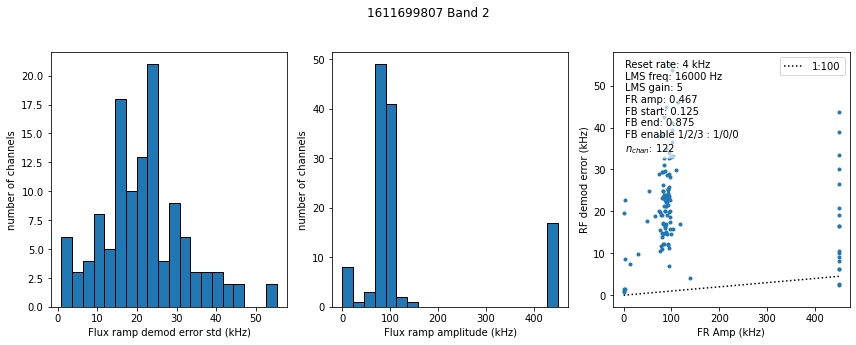

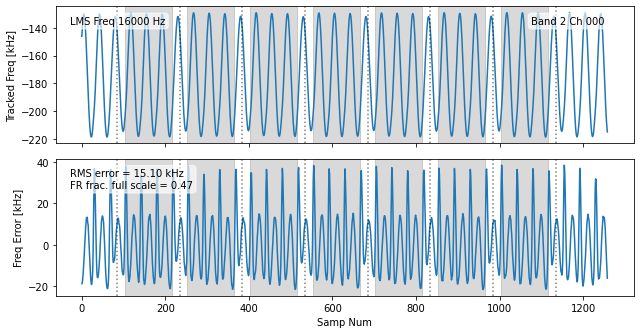

In [20]:
S.set_feedback_gain(2, 2048)
S.tracking_setup(band=2, channel=channel, reset_rate_khz=4, n_phi0=4, lms_freq_hz=None, meas_flux_ramp_amp=True, make_plot=True, lms_gain=5, feedback_start_frac=0.125, feedback_end_frac=1-0.125, lms_enable1=1, lms_enable2=0, lms_enable3=0) 

The plots are an overall tuning summary (tracked frequency throw, RMS tracking error) and a channel plot for the requested channel.  Here we see tracked frequency is aroudn -80kHz to -40kHz for 4 phi0.  The dottled lines indicate flux ramp reset and the grey area shows what part of the response we are tracking.  The bottom plot shows frequency errror.  Here we are only tracking the 16kHz and the error shows this.

Next let's try tracking 3 harmonics of the phi0 rate.

(array([[-1.54775190e-01,  0.00000000e+00, -2.46999979e-01, ...,
          0.00000000e+00,  0.00000000e+00,  4.52041626e-05],
        [-1.53065443e-01,  0.00000000e+00, -2.46999979e-01, ...,
          0.00000000e+00,  0.00000000e+00,  4.57763672e-05],
        [-1.52331734e-01,  0.00000000e+00, -2.46999979e-01, ...,
          0.00000000e+00,  0.00000000e+00,  4.63485718e-05],
        ...,
        [-1.56051636e-01,  0.00000000e+00, -2.46999979e-01, ...,
          0.00000000e+00,  0.00000000e+00,  7.78198242e-05],
        [-1.52208710e-01,  0.00000000e+00, -2.46999979e-01, ...,
          0.00000000e+00,  0.00000000e+00,  7.83920288e-05],
        [-1.51570415e-01,  0.00000000e+00, -2.46999979e-01, ...,
          0.00000000e+00,  0.00000000e+00,  7.89642334e-05]]),
 array([[ 4.06007767e-03,  0.00000000e+00, -1.45448685e-02, ...,
          0.00000000e+00,  0.00000000e+00,  4.50611115e-05],
        [ 3.46655846e-03,  0.00000000e+00, -1.39753819e-02, ...,
          0.00000000e+00,  0.00000000e

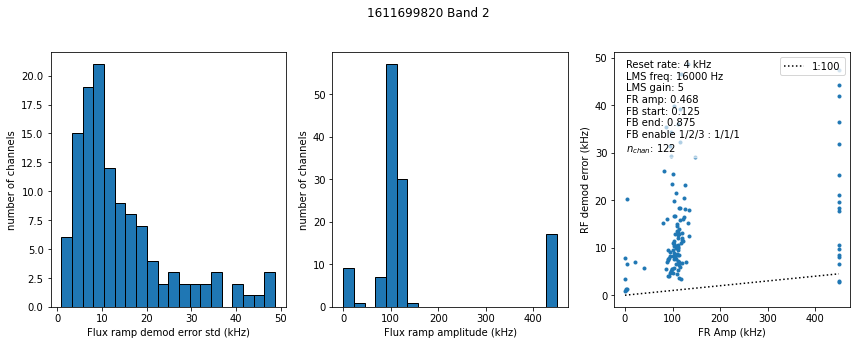

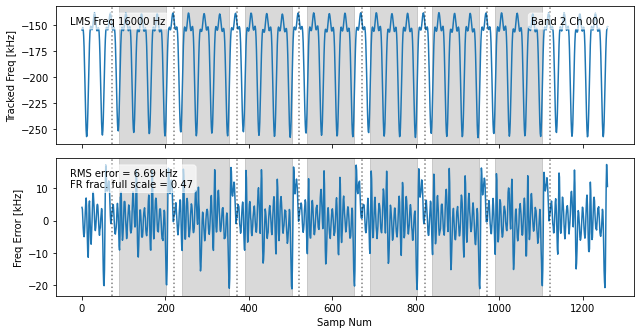

In [21]:
S.tracking_setup(band=2, channel=channel, reset_rate_khz=4, n_phi0=4, lms_freq_hz=None, meas_flux_ramp_amp=True, make_plot=True, lms_gain=5, feedback_start_frac=0.125, feedback_end_frac=1-0.125, lms_enable1=1, lms_enable2=1, lms_enable3=1) 

Our error signal is cleaned up and we are now tracking 3 harmonics of the phi0 response.

### Check lock
Next we perform the function check_lock.  This will look at tracking errors for each resonator and turn off one with poor tracking performance.

In [26]:
n_before = len(S.which_on(2))
S.check_lock(2)
n_after = len(S.which_on(2))
print(f'There were {n_before} tones on before check lock.  Now {n_after}.')
print(f'Check lock killed {n_before - n_after} bad resonators')

There were 88 tones on before check lock.  Now 88.
Check lock killed 0 bad resonators


### Identifiying bias groups
Next we'll identify TES bias groups

Processing data records from /data/smurf_data/20210126/1611699241/outputs/1611700202.dat
Processed 600 data records from /data/smurf_data/20210126/1611699241/outputs/1611700202.dat
Processed a total of 600 data records
Processing data records from /data/smurf_data/20210126/1611699241/outputs/1611700213.dat
Processed 601 data records from /data/smurf_data/20210126/1611699241/outputs/1611700213.dat
Processed a total of 601 data records
Processing data records from /data/smurf_data/20210126/1611699241/outputs/1611700222.dat
Processed 600 data records from /data/smurf_data/20210126/1611699241/outputs/1611700222.dat
Processed a total of 600 data records
Processing data records from /data/smurf_data/20210126/1611699241/outputs/1611700232.dat
Processed 601 data records from /data/smurf_data/20210126/1611699241/outputs/1611700232.dat
Processed a total of 601 data records
Processing data records from /data/smurf_data/20210126/1611699241/outputs/1611700241.dat
Processed 600 data records from /da

{0: {'band': array([], dtype=int64),
  'channel': array([], dtype=int64),
  'freq': array([], dtype=float64)},
 1: {'band': array([2, 2]),
  'channel': array([256, 443]),
  'freq': array([5251.696, 5167.098])},
 2: {'band': array([2, 2, 2]),
  'channel': array([ 16,  48, 200]),
  'freq': array([5269.242, 5278.458, 5296.138])},
 3: {'band': array([2]), 'channel': array([498]), 'freq': array([5440.358])},
 4: {'band': array([], dtype=int64),
  'channel': array([], dtype=int64),
  'freq': array([], dtype=float64)},
 5: {'band': array([], dtype=int64),
  'channel': array([], dtype=int64),
  'freq': array([], dtype=float64)},
 6: {'band': array([], dtype=int64),
  'channel': array([], dtype=int64),
  'freq': array([], dtype=float64)},
 7: {'band': array([], dtype=int64),
  'channel': array([], dtype=int64),
  'freq': array([], dtype=float64)}}

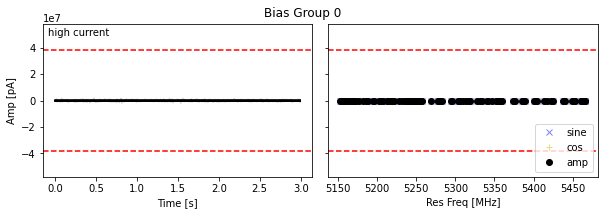

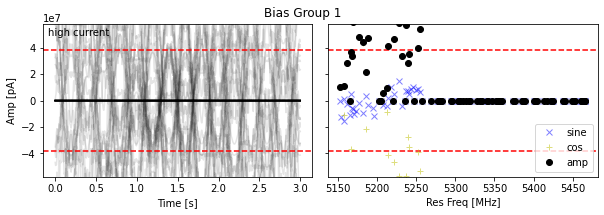

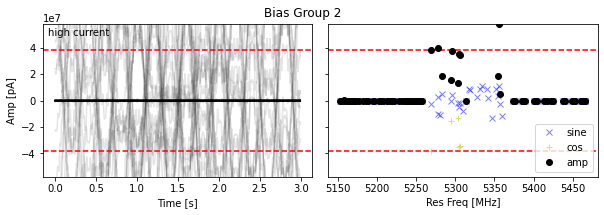

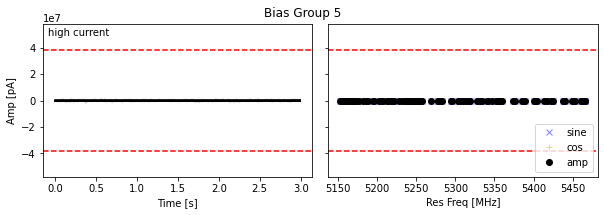

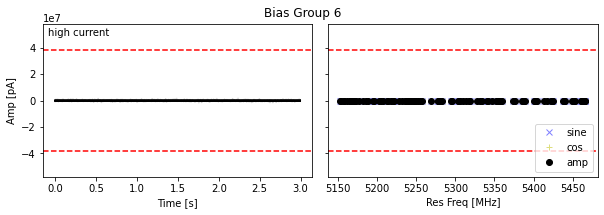

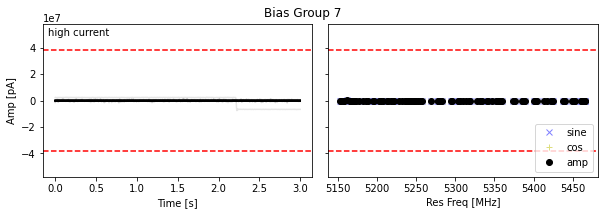

In [27]:
S.identify_bias_groups(bias_groups=range(8), make_plot=True, show_plot=True, save_plot=True, update_channel_assignment=True)

Let's save our current tune state

In [28]:
S.save_tune()

'/data/smurf_data/tune/1611700302_tune.npy'

### IV Data
Now let's take an IV on each bias group

In [29]:
S.run_iv(range(8), overbias_voltage=19.1, 
         bias_high=10, bias_step=0.01,
         wait_time=0.1, high_current_mode=False, 
         overbias_wait=0.5, cool_wait=60, make_plot=True)

Processing data records from /data/smurf_data/20210126/1611699241/outputs/1611700465.dat
Processed 28874 data records from /data/smurf_data/20210126/1611699241/outputs/1611700465.dat
Processed a total of 28874 data records
[0 1 2 3 4 5 6 7]
[[262144. 262144. 262144. ...      0.      0.      0.]
 [262144. 262144. 262144. ...      0.      0.      0.]
 [262144. 262144. 262144. ...      0.      0.      0.]
 ...
 [     0.      0.      0. ...      0.      0.      0.]
 [     0.      0.      0. ...      0.      0.      0.]
 [     0.      0.      0. ...      0.      0.      0.]]
[6.32563724e-01 1.27088329e+02 2.53544095e+02 3.79999861e+02
 5.06455627e+02 6.32911392e+02]
[ 0.  2.  4.  6.  8. 10.]
[6.32563724e-01 1.27088329e+02 2.53544095e+02 3.79999861e+02
 5.06455627e+02 6.32911392e+02]
[ 0.  2.  4.  6.  8. 10.]
[6.32563724e-01 1.27088329e+02 2.53544095e+02 3.79999861e+02
 5.06455627e+02 6.32911392e+02]
[ 0.  2.  4.  6.  8. 10.]
[6.32563724e-01 1.27088329e+02 2.53544095e+02 3.79999861e+02
 5.06

[6.32563724e-01 1.27088329e+02 2.53544095e+02 3.79999861e+02
 5.06455627e+02 6.32911392e+02]
[ 0.  2.  4.  6.  8. 10.]
[6.32563724e-01 1.27088329e+02 2.53544095e+02 3.79999861e+02
 5.06455627e+02 6.32911392e+02]
[ 0.  2.  4.  6.  8. 10.]
[6.32563724e-01 1.27088329e+02 2.53544095e+02 3.79999861e+02
 5.06455627e+02 6.32911392e+02]
[ 0.  2.  4.  6.  8. 10.]
[6.32563724e-01 1.27088329e+02 2.53544095e+02 3.79999861e+02
 5.06455627e+02 6.32911392e+02]
[ 0.  2.  4.  6.  8. 10.]


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[6.32563724e-01 1.27088329e+02 2.53544095e+02 3.79999861e+02
 5.06455627e+02 6.32911392e+02]
[ 0.  2.  4.  6.  8. 10.]
[6.32563724e-01 1.27088329e+02 2.53544095e+02 3.79999861e+02
 5.06455627e+02 6.32911392e+02]
[ 0.  2.  4.  6.  8. 10.]
[6.32563724e-01 1.27088329e+02 2.53544095e+02 3.79999861e+02
 5.06455627e+02 6.32911392e+02]
[ 0.  2.  4.  6.  8. 10.]
[6.32563724e-01 1.27088329e+02 2.53544095e+02 3.79999861e+02
 5.06455627e+02 6.32911392e+02]
[ 0.  2.  4.  6.  8. 10.]
[6.32563724e-01 1.27088329e+02 2.53544095e+02 3.79999861e+02
 5.06455627e+02 6.32911392e+02]
[ 0.  2.  4.  6.  8. 10.]
[6.32563724e-01 1.27088329e+02 2.53544095e+02 3.79999861e+02
 5.06455627e+02 6.32911392e+02]
[ 0.  2.  4.  6.  8. 10.]


'/data/smurf_data/20210126/1611699241/outputs/1611700465_iv_raw_data.npy'

### Take noise PSD

In [30]:
S.take_noise_psd(60, make_channel_plot=True, make_summary_plot=True)

Processing data records from /data/smurf_data/20210126/1611699241/outputs/1611700982.dat
Processed 12012 data records from /data/smurf_data/20210126/1611699241/outputs/1611700982.dat
Processed a total of 12012 data records


'/data/smurf_data/20210126/1611699241/outputs/1611700982.dat'

Here's an example timestream plot from the plot directory

In [32]:
S.plot_dir

'/data/smurf_data/20210126/1611699241/plots'

### Examine DAC output
We can again look at the DAC output but this time we will be playing tones and doing flux ramp tracking:


In [33]:
dac_data = S.read_dac_data(data_length=2**16, band=2, make_plot=True, show_plot=True)

In [34]:
adc_data = S.read_adc_data(data_length=2**16, band=2, make_plot=True, show_plot=True)

Our resonator at 0MHz had the largest depth and we can see the power at the ADC is lowest.

### Turn everything off

In [35]:
S.all_off()        # turn everything off (expect amplifiers)
S.C.write_ps_en(0) # turns off amplifiers